# Nonlinear Optimization Exercise Session 5

Maximilian Stollmayer

In [1]:
using LinearAlgebra
using Plots

### 33. Variations of the Gradient Algorithm

Solve the minimization problem
$$ \min_{x \in \mathbb{R}} f(x) $$
where
$$ f : \mathbb{R}^n \to \mathbb{R}, f(x) = \begin{cases} \frac{1}{c} \| x \| - \frac{1}{2 c^2}, && \text{if} \ \| x \| \ge \frac{1}{c} \\ \frac{1}{c} \| x \|^2, && \text{otherwise} \end{cases}, $$

with the gradient algorithm and the fast gradient algorithm

- by considering different values for the dimension $n \in \{1, 10, 50, 500, 5000\}$ and for the parameter $c > 0$
- by using the Nesterov rule and the Chambolle-Dossal rule for the momentum parameters
- by using different values for the starting point $x^0$

Run the two algorithms with step size $\gamma = \frac{1}{L_{\nabla f}}$ for 200 iterations and display $\big(\|x^k\|\big)_{k=0,\dots,200}$ and $\big(f(x^k)\big)_{k=0,\dots,200}$ as functions of the number of iterations $k$.

In [2]:
function gradientAlgorithmArmijo(
    f::Function,
    g::Function,
    x0::Vector,
    β::Real,
    σ::Real,
    k::Integer
)

    @assert k > 0 "Number of iterations is not positive, got $k."

    x = [x0]
    d = -g(x[1])

    for _ ∈ 1:k
        fx = f(x[end])
        σnorm = σ * norm(d)
        k = 0
        t = 1

        # iterate exponent k until Armijo condition is met
        while f(x[end] + t * d) > fx - t * σnorm
            k = k + 1
            t = β^k
        end

        push!(x, x[end] + t * d)
        d = -g(x[end])
    end

    return x
end
;

In [3]:
function gradientAlgorithmNesterov(
    f::Function,
    g::Function,
    x0::Vector,
    γ::Real,
    k::Integer
)

    @assert k > 0 "Number of iterations is not positive, got $k."

    x = [x0, x0]
    t_old = 1
    d = -g(x[1])

    for _ ∈ 2:k
        t_new = (1 + sqrt(4 * t_old^2 + 1)) / 2
        y = x[end] + (t_old - 1) / t_new * (x[end] - x[end-1])
        push!(x, y - γ * g(y))
        d = -g(x[end])
        t_old = t_new
    end

    return x
end
;

In [4]:
function gradientAlgorithmChambolleDossal(
    f::Function,
    g::Function,
    x0::Vector,
    γ::Real,
    α::Real,
    k::Integer
)
    
    @assert k > 0 "Number of iterations is not positive, got $k."

    x = [x0, x0]
    t_old = 1
    d = -g(x[1])

    for _ ∈ 2:k
        t_new = (length(x) + α - 2) / (α - 1)
        y = x[end] + (t_old - 1) / t_new * (x[end] - x[end-1])
        push!(x, y - γ * g(y))
        d = -g(x[end])
        t_old = t_new
    end

    return x
end
;

In [30]:
function plotIterations(ns::Vector{Int}, c::Real, β::Real, σ::Real, α::Real, k::Integer)
    function f(x::AbstractVector)
        nx = norm(x)
        return nx >= 1/c ? nx/c - 1/(2*c^2) : nx^2 / 2
    end
    
    function g(x::AbstractVector)
        nx = norm(x)
        nx >= 1/c ? x / nx / c : x
    end

    for n ∈ ns
        x = 2*rand(n) .- 1
        γ = 1 / sqrt(n) # 1 / Lipschitz constant
        Armijo = gradientAlgorithmArmijo(f, g, x, β, σ, k)
        Nesterov = gradientAlgorithmNesterov(f, g, x, γ, k)
        ChambolleDossal = gradientAlgorithmChambolleDossal(f, g, x, γ, α, k)
        norms = plot(
            0:k,
            [norm.(Armijo).+eps(), norm.(Nesterov).+eps(), norm.(ChambolleDossal).+eps()],
            yscale=:log10,
            title="n=$n",
            ylabel="||xᵏ||",
            label=["Armijo" "Nesterov" "Chambolle-Dossal"],
        );
        fs = plot(
            0:k,
            [f.(Armijo).+eps(), f.(Nesterov).+eps(), f.(ChambolleDossal).+eps()],
            yscale=:log10,
            xlabel="iterations",
            ylabel="f(xᵏ)",
            legend=false
        );
        display(plot(norms, fs, layout=(2,1)))
    end
end
;

In [31]:
ns = [1, 10, 50, 500, 5000]
β = 0.5  # parameter of Armijo rule
σ = 0.01 # parameter of Armijo rule
α = 3.01 # parameter of Chambolle-Dossal rule
k = 200  # number of iterations
;

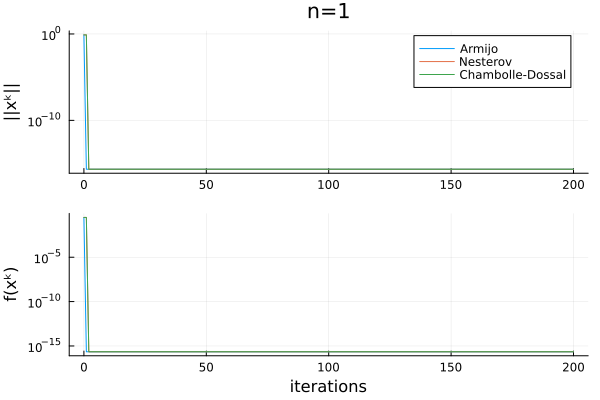

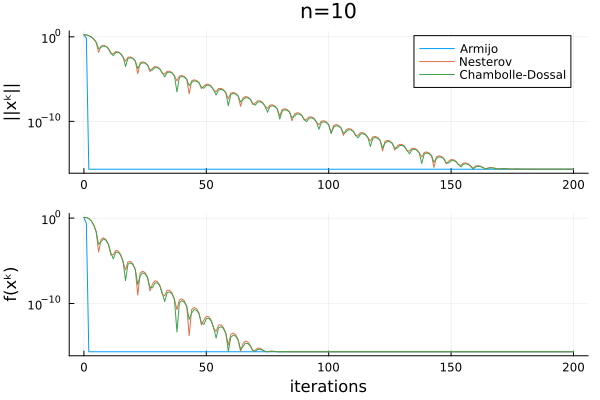

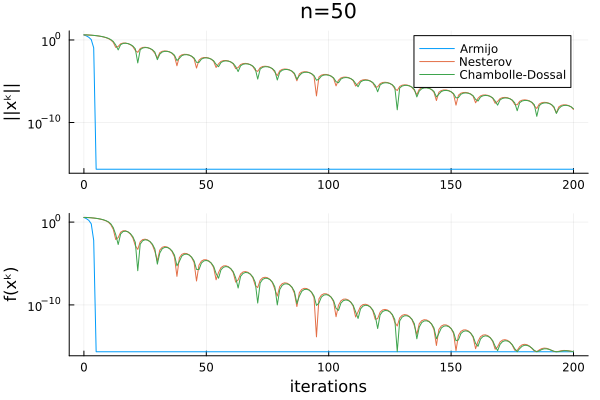

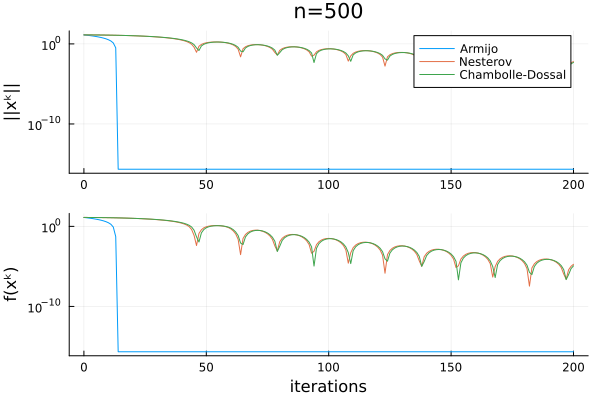

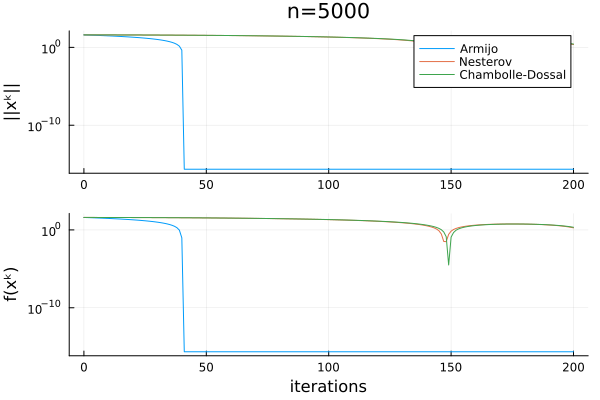

In [32]:
c = 1
plotIterations(ns, c, β, σ, α, k)

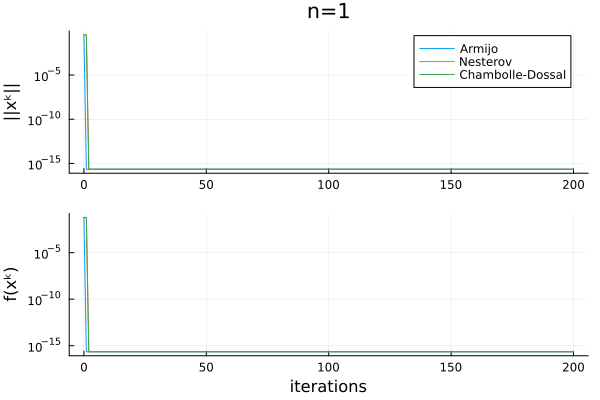

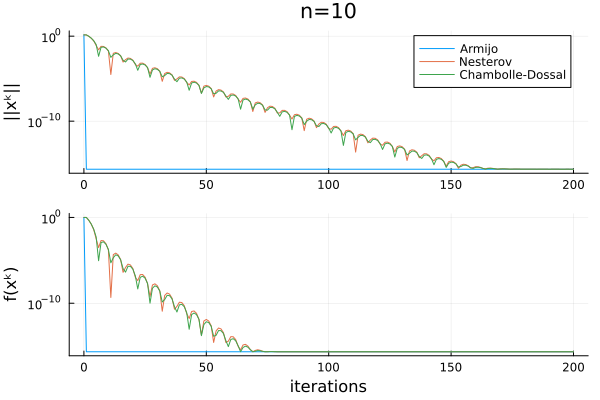

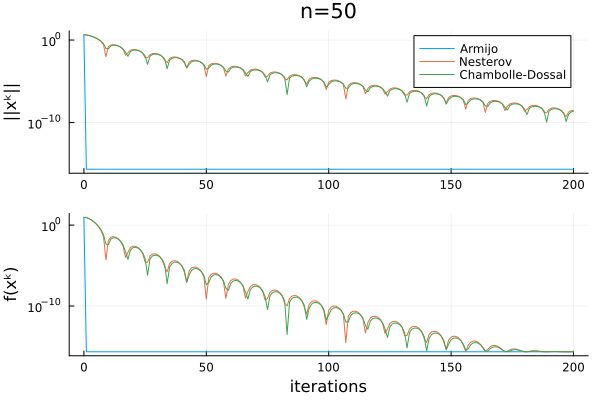

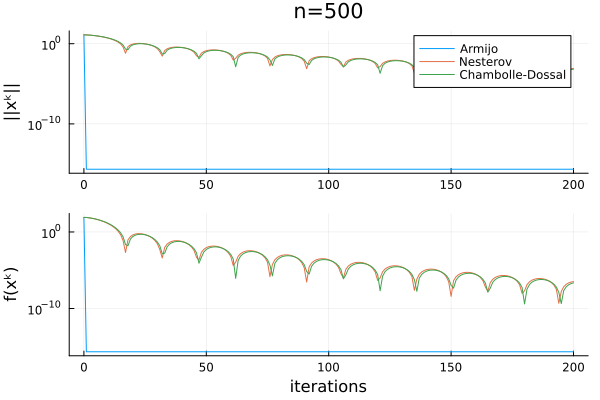

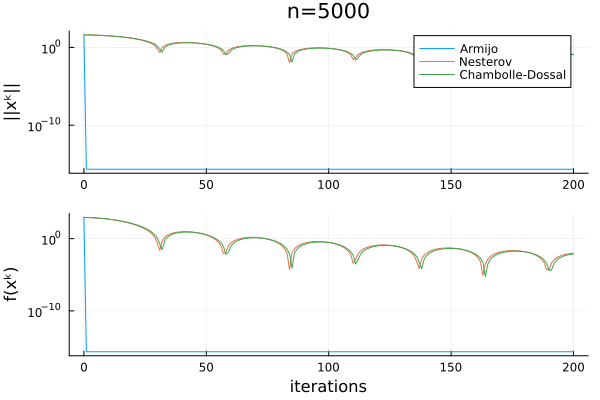

In [33]:
c = 0.01
plotIterations(ns, c, β, σ, α, k)

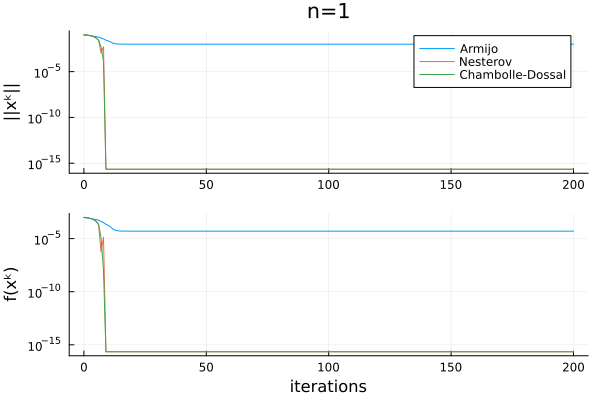

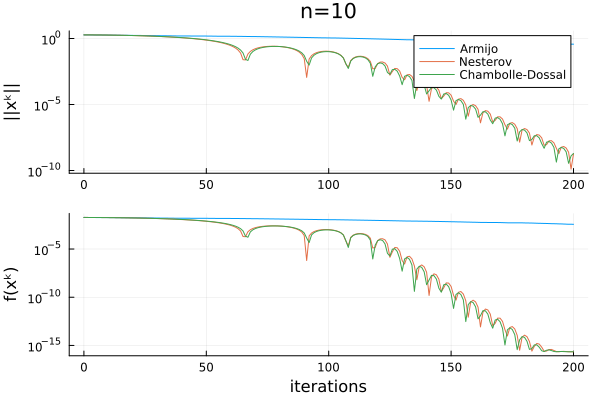

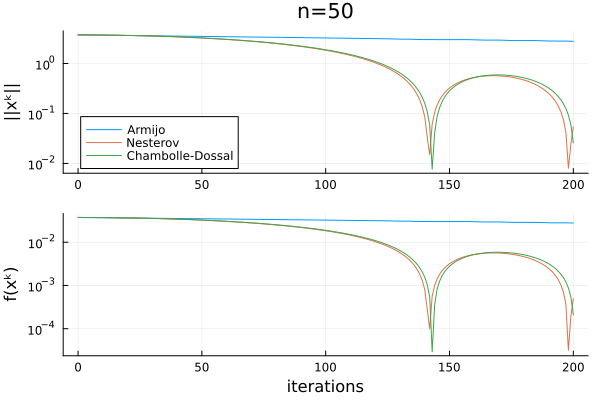

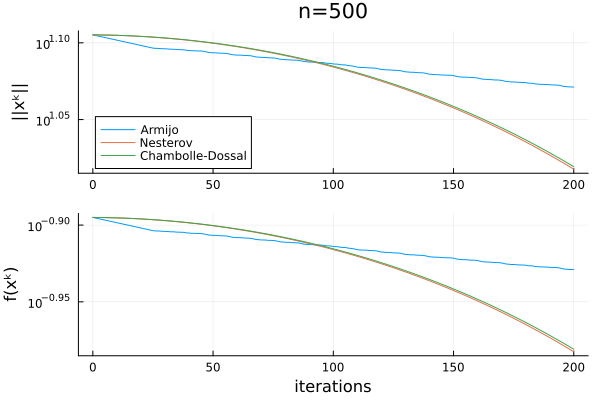

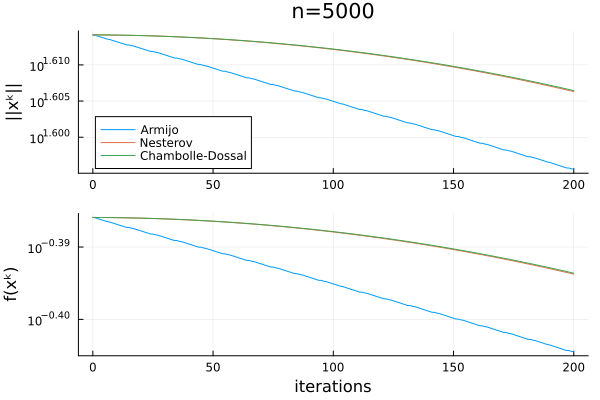

In [34]:
c = 100
plotIterations(ns, c, β, σ, α, k)

### 34. Implementation of CG Algorithm

Implement the CG algorithm for linear systems (Algorithm 8.2). Use as input data the symmetric and positive definite matrix $A$, the vector $b$, the starting vector $x^0$ and the parameter for the stopping criterion $\varepsilon$. The solution $x^*$ and the number of performed iterations should be returned.

In [12]:
function CG(A::AbstractMatrix, b::AbstractVector, x0::AbstractVector, tol::Real)

    n = size(A, 1)

    @assert size(A, 2) == n "Matrix has to be square, got $n by $(size(A, 2))."
    @assert size(b, 1) == n "System vector has to be of size $n, got $(size(b, 1))."
    @assert size(x0, 1) == n "Starting vector has to be of size $n, got $(size(x0, 1))."
    @assert tol >= 0 "Tolerance has to be greater than zero, got $tol."

    x_old = x0
    g_old = A * x_old - b
    norm_old = norm(g_old)^2
    d_old = -g_old
    tol = tol^2
    n_iterations = 0
    
    while norm_old > tol && n_iterations < n
        # calculate new iterates
        Ad = A * d_old
        t = norm_old / dot(d_old, Ad)
        x_new = x_old + t * d_old
        g_new = g_old + t * Ad
        norm_new = norm(g_new)^2
        β = norm_new / norm_old
        d_new = -g_new + β * d_old

        # update old variables
        x_old = x_new
        g_old = g_new
        norm_old = norm_new
        d_old = d_new
        n_iterations += 1
    end

    return x_old, n_iterations
end
;

Test the algorithm on the following optimization problems and input data values:

(a) Minimize the function
$$ f(x_1, x_2) = 2x_1^2 + x_2^2 - 4x_1 - 2x_2 + 3 $$
over $\mathbb{R}^2$, for $x^0 = (5, -5)^\top$ and $\varepsilon = 10^{-3}$.

In [13]:
A = [4 0; 0 2]
b = [4; 2]
x0 = [5; -5]
tol = 1e-3
;

In [14]:
x, n_iterations = CG(A, b, x0, tol)

([1.0, 1.0000000000000004], 2)

In [5]:
# optimality condition
all(isapprox.(A * x - b, 0, atol=1e-8))

true

In [6]:
# minimum value
dot(x, A, x) / 2 - dot(b, x) + 3

0.0

(b) Minimize the function
$$ f(x_1, x_2, x_3) = x_1^2 + 0.3 x_1 x_2 + 0.975 x_2^2 + 0.01 x_1 x_3 + x_3^2 + 3x_1 - 4x_2 + x_3 $$
over $\mathbb{R}^3$, for $x^0 = (0, 0, 0)^\top$ and $\varepsilon = 10^{-8}$.

In [15]:
A = [2 0.3 0.01; 0.3 0.975*2 0; 0.01 0 2]
b = [-3; 4; -1]
x0 = [0; 0; 0]
tol = 1e-8
;

In [16]:
x, n_iterations = CG(A, b, x0, tol)

([-1.8478819339864998, 2.3355715795876666, -0.4907605903300675], 3)

In [17]:
# optimality condition
all(isapprox.(A * x - b, 0, atol=1e-8))

true

In [18]:
# minimum value
dot(x, A, x) / 2 - dot(b, x)

-4.688346355320117